In [1]:
from BIDS.snapshot2D import create_snapshot,Snapshot_Frame,Visualization_Type,Image_Modes
from pathlib import Path
from IPython.display import Image
import numpy as np
from BIDS import Centroids
from scipy import interpolate
import sys

WORKING_DIR = "/home/daniel/Documents/Uni/practical-sose23/"
HOME_DIR = "/home/daniel/"

sys.path.append(WORKING_DIR + "castellvi/3D-Castellvi-Prediction/src/utils")
from _prepare_data import *

from BIDS import BIDS_FILE, Centroids, Image_Reference, Centroid_Reference, NII
from BIDS.snapshot2D.snapshot_modular import Snapshot_Frame,create_snapshot, Visualization_Type
from pathlib import Path

####################################
/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/daniel/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/daniel/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/daniel/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/h

In [2]:
def fit_spline(centroids: Centroids, max_dim: int, smoothness: int=10) -> tuple[np.ndarray, np.ndarray]:
    """Makes a spline interpolation through the pointset and calculates the first derivative of the curve.

    Args:
        centroids: Given Centroids
        max_dim: int(max(img.shape))

    Returns:
        spline_points: np.array, spline_1stderivative: np.array
    """
    centroids_coords = list(centroids.sort().values())
    centroids_coords = np.asarray(centroids_coords)
    x_sample = centroids_coords[:, 0]
    y_sample = centroids_coords[:, 1]
    z_sample = centroids_coords[:, 2]
    tck, u = interpolate.splprep([x_sample,y_sample,z_sample], k=2, s=smoothness)
    u_fine = np.linspace(0, 1, max_dim)
    x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)
    xp_fine, yp_fine, zp_fine = interpolate.splev(u_fine, tck, der=1)
    #xp_fine = np.diff(x_fine)/np.diff(np.linspace(0, max(y_sample)-min(y_sample), max_dim))
    #xp_fine = np.concatenate((xp_fine, np.asarray([xp_fine[-1]])))
    #yp_fine = np.diff(y_fine)/np.diff(np.linspace(0, max(y_sample)-min(y_sample), max_dim))
    #yp_fine = np.concatenate((yp_fine, np.asarray([yp_fine[-1]])))
    #zp_fine = np.diff(z_fine)/np.diff(np.linspace(0, max(y_sample)-min(y_sample), max_dim))
    #zp_fine = np.concatenate((zp_fine, np.asarray([zp_fine[-1]])))#attach the last element missing after diff
    #if centroids.shape[0]>3:
    #     min_tilt_point, max_tilt_point = get_max_tilt(np.asarray([x_fine, y_fine, z_fine]), np.asarray([xp_fine, yp_fine, zp_fine]))
    return np.asarray(list(zip(x_fine, y_fine, z_fine))), np.asarray(list(zip(xp_fine, yp_fine, zp_fine)))

In [3]:
WORKING_DIR = "/home/daniel/Documents/Uni/practical-sose23/"
dataset = [WORKING_DIR  + 'dataset-verse19',  WORKING_DIR + 'dataset-verse20']
data_types = ['rawdata',"derivatives"]
image_types = ["ct", "subreg", "cortex"]
master_list = WORKING_DIR + 'castellvi/3D-Castellvi-Prediction/src/dataset/VerSe_masterlist.xlsx'
processor = DataHandler(master_list=master_list ,dataset=dataset, data_types=data_types, image_types=image_types)

[!] Unknown format seg-ano in file sub-verse602_dir-iso_seg-ano.nii.gz
[!] Unknown format iso-ctd in file sub-verse616_dir-iso_iso-ctd.json
[!] Unknown format subreg in file sub-verse559_CT-sag_seg-ano_subreg.nii.gz


In [4]:
def calculate_angle_dist(ctd: Centroids):
    last_L = 25 if 25 in ctd.centroids.keys() else 24 if 24 in ctd.centroids.keys() else 23 if 23 in ctd.centroids.keys() else None
    assert(last_L is not None)
    prev_L = last_L - 1
    sac = 26

    assert(prev_L in ctd.centroids.keys())
    assert(sac in ctd.centroids.keys())

    v1 = np.asarray(ctd.centroids[last_L]) - np.asarray(ctd.centroids[prev_L])
    v2 = np.asarray(ctd.centroids[last_L]) - np.asarray(ctd.centroids[sac])

    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

    #calculate distance between last_L and sac
    dist = np.linalg.norm(np.asarray(ctd.centroids[last_L]) - np.asarray(ctd.centroids[sac]))

    return angle, dist

In [23]:
angles = []
labels = []
records = []
distances = []

castellvi_encoding = {
    '0': 0,
    '1a': 10,
    '1b': 11,
    '2a': 20,
    '2b': 21,
    '3a': 30,
    '3b': 31,
    '4': 40,
}

for record in processor.verse_records:
    ctd = record["ctd_file"].open_cdt()
    ct = record["raw_file"].open_nii()
    ctd.zoom = ct.zoom
    if not ctd.shape:
        ctd.shape = ct.shape
    ctd = ctd.rescale((1,1,1), verbose=False)
    if not record["flip"]:
        try:
            angle, dist = calculate_angle_dist(ctd)
            if dist < 20:
                continue
            angles.append(angle)
            distances.append(dist)
            labels.append(castellvi_encoding[record['castellvi']])
            records.append(record)
        except:
            print("Error in record: ", record['subject'])

#Sort arrays by angle
angles = np.asarray(angles)
angle_sort_idx = np.argsort(angles)

#Sort arrays by distance
distances = np.asarray(distances)
dist_sort_idx = np.argsort(distances)

Error in record:  verse034
Error in record:  verse116


In [24]:
# Print count of each label
print("Count of each label: ", np.unique(labels, return_counts=True))

Count of each label:  (array([ 0, 10, 11, 20, 21, 30, 31, 40]), array([143,  15,  21,  34,  26,  13,  22,   7]))


In [7]:
# Discard random 0 labels to balance dataset

# Get indices of 0 labels
zero_idx = np.where(np.asarray(labels) == 0)[0]
# Get indices of 1 labels
one_idx = np.where(np.asarray(labels) == 1)[0]

# Get random indices of 0 labels
random_zero_idx = np.random.choice(zero_idx, len(one_idx), replace=False)

# Concatenate indices
idx = np.concatenate((random_zero_idx, one_idx))

angles = angles[idx]
labels = [labels[i] for i in idx]
records = [records[i] for i in idx]
distances = distances[idx]

In [8]:
# Print count of each label
print("Count of each label: ", np.unique(labels, return_counts=True))

Count of each label:  (array([], dtype=float64), array([], dtype=int64))


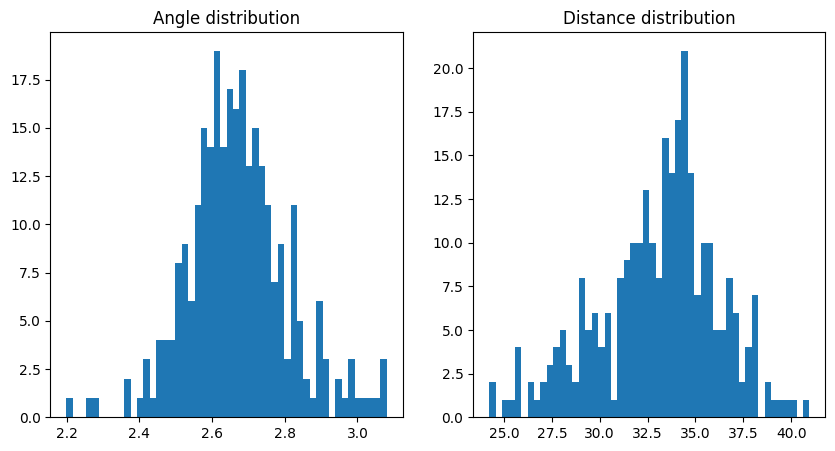

In [11]:
# Plot dsitribtion of angles and distances side by side
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(angles, bins=50)
axs[0].set_title("Angle distribution")
axs[1].hist(distances, bins=50)
axs[1].set_title("Distance distribution")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


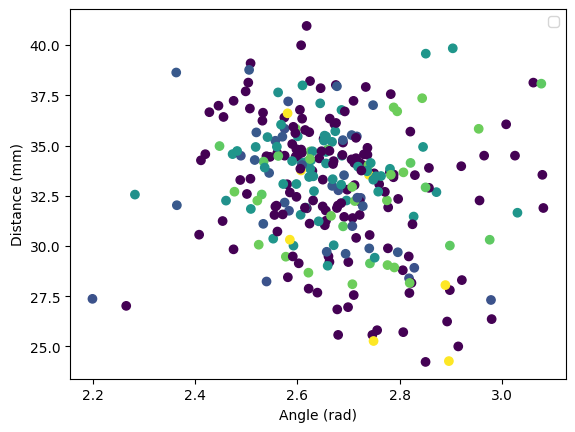

In [25]:
#Plot angle-distance as scatter plot colored by label with legend for color coding
scatter = plt.scatter(angles, distances, c=labels)
plt.xlabel("Angle (rad)")
plt.ylabel("Distance (mm)")
plt.legend()
plt.show()

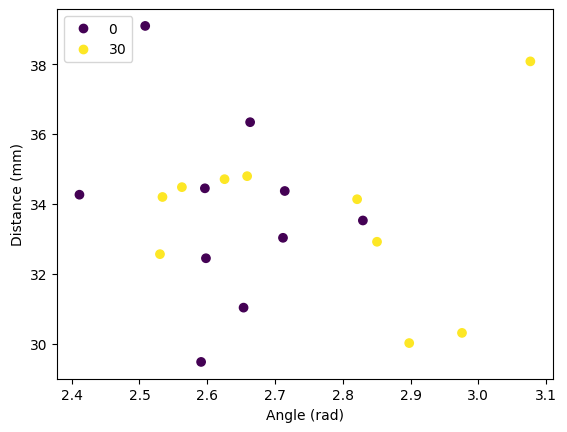

In [27]:
#Select k random records with label 0 and 20 random records with label 31
k = 10
zero_idx = np.where(np.asarray(labels) == 0)[0]
one_idx = np.where(np.asarray(labels) == 30)[0]

random_zero_idx = np.random.choice(zero_idx, k, replace=False)
random_one_idx = np.random.choice(one_idx, k, replace=False)

random_idx = np.concatenate((random_zero_idx, random_one_idx))

#Plot angle-distance as scatter plot colored by label with legend for color coding
scatter = plt.scatter(angles[random_idx], distances[random_idx], c=[labels[i] for i in random_idx])
plt.xlabel("Angle (rad)")
plt.ylabel("Distance (mm)")
plt.legend(*scatter.legend_elements())
plt.show()

Accuracy:  0.47368421052631576
Confusion matrix:  [[13  5]
 [15  5]]
ROC AUC:  0.4861111111111111
Average precision score:  0.5197368421052632


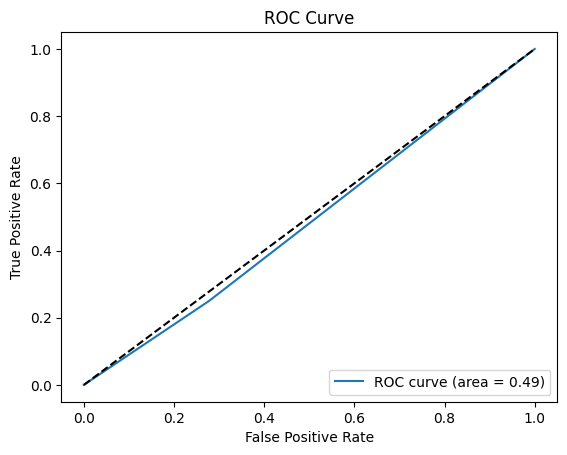

In [11]:
#fit two-dimensional logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

X = np.asarray(list(zip(angles, distances)))
y = np.asarray(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion matrix: ", confusion_matrix(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print("Average precision score: ", average_precision_score(y_test, y_pred))


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



The AUC score indicates a performance that is only a tiny bit better than random choice. We conclude that the angle between the last vertebrae alone is not indicative enough of the true castellvi label.

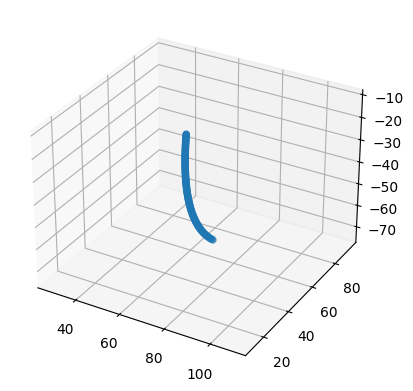

In [28]:
ct, seg, ctd = processor.get_ct_seg_ctd_cutout(records[0])
spline, spline_der = fit_spline(ctd, max_dim = 128)

# Plot spline as set of 3D points with equal spacing
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(spline[:,2], spline[:,0], -spline[:,1])
ax.axis('equal')
plt.show()
